In [28]:
import numpy as np
import pandas as pd
df = pd.read_csv('/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/marriott_hotel_reviews.csv')
# df['Total_Score'].value_counts().max()/df.shape[0]

### Clean Text Data

In [29]:
df['Review']=df['Review'].astype(str)

In [30]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

'''
Part-Of-Speech (POS) tagging: assign a tag to every word to define 
if it corresponds to a noun, a verb etc. using the WordNet lexical database
'''

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [31]:
def clean_text(text):
    # lower text
    text = text.lower()
    #
    text = text.replace("n't"," not")
    text = text.replace("i'm","i am")
    text = text.replace("i'd","i would")
    text = text.replace("i've","i have")
    text = text.replace("we're","we are")
    text = text.replace("'ll"," will")
    text = text.replace("that's","that is")
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text: transform every word into their root form 
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df['Review'] = df['Review'].apply(lambda x: clean_text(x))

### Feature Engineering

In [32]:
# add sentiment anaylsis columns
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

#sid = SentimentIntensityAnalyzer()
#df['sentiments'] = df['Review'].apply(lambda x: sid.polarity_scores(x))
#df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
tfidf = TfidfVectorizer(min_df = 5,max_df=0.5)
tfidf_result = tfidf.fit_transform(df['Review'].astype('U')).toarray()
tfidf_df = pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

### Modelling

#### The classifiers I used
- Random Forest Classifier
- Naive-Bayes Classifier
- KNN Classifier

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge

In [36]:
# deal with unbalanced data

# under sampling

count2 = df['Total_Score'].value_counts().min()

score1 = df[df['Total_Score']==1]
score2 = df[df['Total_Score']==2]
score3 = df[df['Total_Score']==3]
score4 = df[df['Total_Score']==4]
score5 = df[df['Total_Score']==5]

under1 = score1.sample(count2,replace=True)
under3 = score3.sample(count2,replace=True)
under4 = score4.sample(count2,replace=True)
under5 = score5.sample(count2,replace=True)

df = pd.concat([under1,under3,under4,under5,score2],axis=0)

In [37]:
label = 'Total_Score'
features = [c for c in tfidf_df.columns]

X = df[features]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,stratify=y,random_state=42)

In [38]:
def rough_accuracy(y_test,y_pred):
    count = 0
    for i in range(len(y_test)):
        y_test_list = y_test.to_list()
        if ((y_test_list[i] - y_pred[i])>=-1) & ((y_test_list[i] - y_pred[i])<=1):
            count = count+1
    rough_accuracy = count/len(y_test)
    return rough_accuracy

#### 1. Linear regression (Lasso)

In [39]:
# train a linear regression model
lr = LinearRegression()
ridge = Ridge(alpha=0.3)

nmc = 25
testSize = 0.25
shuffle = ShuffleSplit(n_splits=nmc,test_size=testSize)
CVInfo = cross_validate(ridge,X,y,cv=shuffle,return_train_score=True)

# train score and test score
lasso_train_score = np.mean(CVInfo['train_score'])
lasso_test_score = np.mean(CVInfo['test_score'])
print('Train score:',lasso_train_score)
print('Train sd:',np.std(CVInfo['train_score']))
print('Test score:',lasso_test_score)
print('Test sd:',np.std(CVInfo['test_score']))

Train score: 0.7004884270204026
Train sd: 0.013405137888185892
Test score: 0.3864854716915093
Test sd: 0.043551750511098976


#### 2. Random Forest Classifier

In [40]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100)
# n_estimators is the number of trees you want to build before taking the maximum voting or averages of predictions

nmc = 25
testSize = 0.25
shuffle = ShuffleSplit(n_splits=nmc,test_size=testSize)
CVInfo = cross_validate(rf,X,y,cv=shuffle,return_train_score=True)

# train score and test score
rf_train_score = np.mean(CVInfo['train_score'])
rf_test_score = np.mean(CVInfo['test_score'])
print('Train score:',rf_train_score)
print('Train sd:',np.std(CVInfo['train_score']))
print('Test score:',rf_test_score)
print('Test sd:',np.std(CVInfo['test_score']))

Train score: 0.7309022556390978
Train sd: 0.00944619475160266
Test score: 0.4426966292134832
Test sd: 0.02806740673437482


In [41]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Estimate a confusion matrix
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_test, y_pred)
print(cmat)

[[16 10  6  1  3]
 [ 9 10  9  2  5]
 [ 8 13 11  1  3]
 [ 5  2  2 14 13]
 [ 1  2  0  2 30]]


In [42]:
rough_accuracy(y_test,y_pred)

0.7865168539325843

/Users/cynding/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


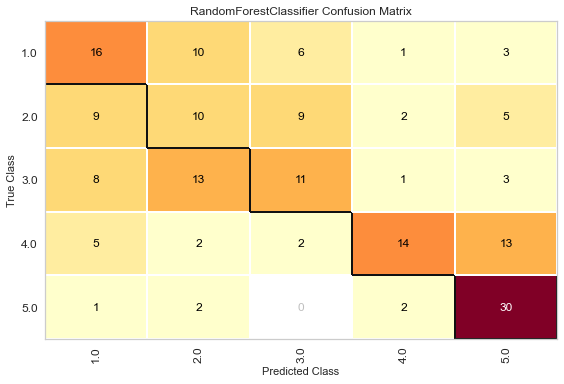

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [43]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(rf)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [44]:
# save the model to disk
import _pickle as pickle
filename = '/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/ml_model.sav'
pickle.dump(rf, open(filename, 'wb'))

#### 3. Naive Bayes Classifier

In [17]:
mnb = MultinomialNB()
nmc = 25
testSize = 0.25
shuffle = ShuffleSplit(n_splits=nmc,test_size=testSize)
CVInfo = cross_validate(rf,X,y,cv=shuffle,return_train_score=True)

mnb_train_score = np.mean(CVInfo['train_score'])
mnb_test_score = np.mean(CVInfo['test_score'])
# train score and test score
print('Train score:',"{:.2%}".format(mnb_train_score))
print('Train sd:',"{:.2%}".format(np.std(CVInfo['train_score'])))
print('Test score:',"{:.2%}".format(mnb_test_score))
print('Test sd:',"{:.2%}".format(np.std(CVInfo['test_score'])))

Train score: 74.44%
Train sd: 0.61%
Test score: 42.22%
Test sd: 3.34%


In [18]:
# train a naive bayes classifier
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

# Estimate a confusion matrix
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_test, y_pred)
print(cmat)

[[14 14  4  2  2]
 [ 7 16  5  7  0]
 [ 5 13 16  1  1]
 [ 2  4  2 16 12]
 [ 2  2  1  8 22]]


In [19]:
rough_accuracy(y_test,y_pred)

0.8202247191011236

/Users/cynding/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


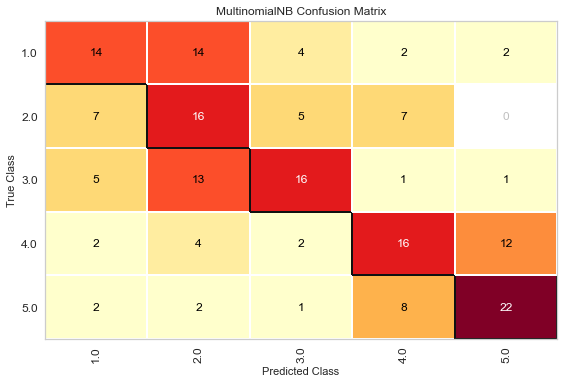

<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [20]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(mnb)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

#### 4. KNN Classifier

In [22]:
# train a knn classifier

# find the number of neighbors with the best performance
nmc = 5
testSize = 0.25
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,101,2)
for i in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors=i)
    shuffle = ShuffleSplit(n_splits=nmc,test_size=testSize)
    CVInfo = cross_validate(knn,X,y,cv=shuffle,return_train_score=True)
    # record train accuracy
    training_accuracy.append(np.mean(CVInfo['train_score']))
    # record test accuracy
    test_accuracy.append(np.mean(CVInfo['test_score']))

In [23]:
maximum = 0
index = []
for i in range(len(test_accuracy)):
    if test_accuracy[i] > maximum:
        maximum = test_accuracy[i]
        index.append(i)
pos= index[-1]
print(neighbors_settings[pos])  

75


The number of neighbors with the best performance is 73.

In [24]:
knn = KNeighborsClassifier(n_neighbors=73)
nmc = 25
testSize = 0.25
shuffle = ShuffleSplit(n_splits=nmc,test_size=testSize)
CVInfo = cross_validate(knn,X,y,cv=shuffle,return_train_score=True)

knn_train_score = np.mean(CVInfo['train_score'])
knn_test_score = np.mean(CVInfo['test_score'])
# train score and test score
print('Train score:',knn_train_score)
print('Train sd:',np.std(CVInfo['train_score']))
print('Test score:',knn_test_score)
print('Test sd:',np.std(CVInfo['test_score']))

Train score: 0.3678195488721805
Train sd: 0.02251073072799515
Test score: 0.310561797752809
Test sd: 0.03684022765181694


In [25]:
knn = KNeighborsClassifier(n_neighbors=73)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Estimate a confusion matrix
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_test, y_pred)
print(cmat)

[[29  0  0  1  6]
 [19  0  6  4  6]
 [23  0  7  2  4]
 [ 3  0  2 20 11]
 [ 6  0  1 13 15]]


In [26]:
rough_accuracy(y_test,y_pred)

0.6966292134831461

In [27]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['Model','Train Score','Test Score']
x.add_row(['Linear Regression (Lasso)',"{:.2%}".format(lasso_train_score),"{:.2%}".format(lasso_test_score)])
x.add_row(['Random Forest',"{:.2%}".format(rf_train_score),"{:.2%}".format(rf_test_score)])
x.add_row(['Naive-Bayes',"{:.2%}".format(mnb_train_score),"{:.2%}".format(mnb_test_score)])
x.add_row(['KNN',"{:.2%}".format(knn_train_score),"{:.2%}".format(knn_test_score)])
print(x)

+---------------------------+-------------+------------+
|           Model           | Train Score | Test Score |
+---------------------------+-------------+------------+
| Linear Regression (Lasso) |    67.93%   |   33.84%   |
|       Random Forest       |    74.71%   |   42.70%   |
|        Naive-Bayes        |    74.44%   |   42.22%   |
|            KNN            |    36.78%   |   31.06%   |
+---------------------------+-------------+------------+


Among these four models, I chose Naive-Bayes as it gets the highest test accuracy with minor overfitting problem.